# EEG 

run this in your terminal window

'''
pip install tensorflow
'''

and then run

'''
pip install nse 
'''

Add required dependencies and download dataset using json

In [1]:
import os
import json
import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import RBF

# Define your MNE config directory
mne_config_dir = os.path.expanduser("~/.mne")
os.makedirs(mne_config_dir, exist_ok=True)

# Write the config JSON file
mne_config = {
    "MNE_DATA": "/Users/jpxmaestas/mne_data"
}
with open(os.path.join(mne_config_dir, "mne-python.json"), "w") as f:
    json.dump(mne_config, f)


In [2]:
from mne.datasets import eegbci
import mne 
import numpy as np

sample_frequency = 50
subject = 2 
runs = [6, 10, 14]
raw_fnames = eegbci.load_data(subject, runs)

raw = mne.io.read_raw_edf(raw_fnames[0], preload=True)
for fname in raw_fnames[1:]:
    raw.append(mne.io.read_raw_edf(fname, preload=True))

Extracting EDF parameters from /Users/jpxmaestas/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /Users/jpxmaestas/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /Users/jpxmaestas/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Respond with 'y'

In [3]:
# Bandpass filter the data (typical for motor imagery)
raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')

# Extract events from annotations
events, _ = mne.events_from_annotations(raw)

# Define motor imagery classes: left = 2, right = 3
event_id = dict(left=2, right=3)

# Create epochs (4s trials starting at event onset)
epochs = mne.Epochs(
    raw, events, event_id, tmin=0., tmax=4., baseline=None,
    reject_by_annotation=False, preload=True
)

# Extract the data and labels
X = epochs.get_data()  # shape: (n_trials, n_channels, n_times)
y = epochs.events[:, -1]


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 641 original time points ...
0 bad epochs dropped


# EDA

Now, we need to process and visualize the data in order to make better inference on which.

In [4]:
# Pick channel name (e.g., 'C3..' or 'C3' after renaming)
channel = 'all'
channel_c4 = 'data'
data, times = raw.copy().pick(channel).get_data(return_times=True)

import pandas as pd

# data has shape (1, n_times) — so take the first row
df = pd.DataFrame({
    'time': times,
    channel: data[0]
})

/var/folders/p9/n04hcd657r93rwljz4zpmh1w0000gn/T/ipykernel_55062/4114851563.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


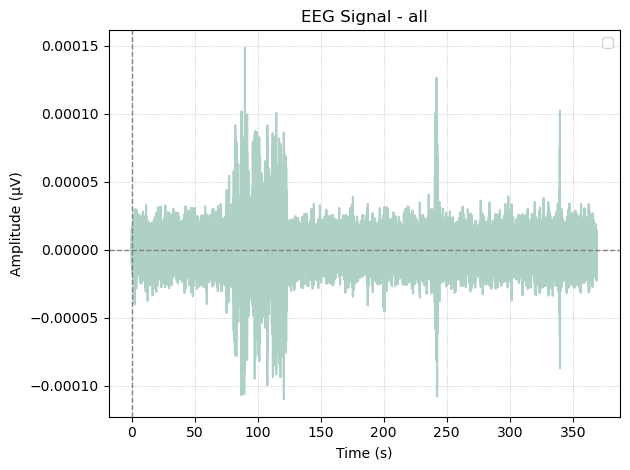

In [5]:
plt.plot(df['time'], df[channel],color='#afd1c3')
plt.title(f"EEG Signal - {channel}")


plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)

# Add horizontal line at amplitude = 0
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)

plt.xlabel("Time (s)")
plt.ylabel("Amplitude (μV)")
plt.legend()
plt.grid(True, which='both', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()

# Begin Processing Data

In [6]:
print(len(df[channel]))
print(len(df['time']))
print(X)
print(y)

59040
59040
[[[ 6.64410565e-06  9.08455980e-07 -3.95759498e-06 ...  3.50372082e-06
    8.91080940e-06  8.57143953e-06]
  [-9.58963313e-06 -8.42754533e-06 -1.20389883e-06 ...  4.02644432e-07
    7.98630480e-06  8.34019233e-06]
  [-1.82159688e-05 -1.17517939e-05  3.09558315e-06 ... -3.08714527e-06
    5.57959401e-06  6.80528824e-06]
  ...
  [ 4.96542592e-06  1.01597578e-08 -6.87184559e-06 ...  1.14675148e-05
    7.43572044e-06 -3.06768488e-06]
  [ 4.71556991e-06 -7.36578543e-07 -1.01683453e-05 ...  1.04606854e-05
   -1.92648472e-06 -1.84331191e-05]
  [ 5.60668077e-06  5.77300426e-09 -7.52041079e-06 ...  1.14879103e-05
    6.66435624e-06 -3.98625625e-06]]

 [[-2.56970213e-06  6.89221579e-06  1.49973214e-05 ...  1.70663585e-06
   -3.57850906e-06 -3.62745636e-06]
  [-5.90746593e-06  7.54319005e-06  1.98562000e-05 ...  6.95162679e-06
   -8.95588610e-07 -6.76235194e-06]
  [-1.15647347e-05  7.20683927e-06  2.26833364e-05 ...  1.09085257e-05
   -2.11284836e-06 -1.26838861e-05]
  ...
  [-6.24024

# Processing

Raw EEG data is special in that we need to slice it into fixed length segments known as epochs. The purpose of which is to process the action of motor activity.

In [7]:
from mne.datasets import eegbci
from mne import Epochs, events_from_annotations

# If you haven't already:
events, _ = events_from_annotations(raw)
event_id = dict(left=2, right=3)  # use appropriate IDs

epochs = Epochs(raw, events, event_id=event_id, tmin=0., tmax=4.,
                baseline=None, preload=True, reject_by_annotation=False)


Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 641 original time points ...
0 bad epochs dropped


The Epochs module has denoted within intervals of 4 seconds, there are 45 neurological events

In [8]:
X = epochs.get_data()  # shape: (n_epochs, n_channels, n_times)
y = pd.Series(epochs.events[:, -1])  # Labels (e.g., 2 = left, 3 = right)

In [9]:
X = (X - X.mean(axis=(1, 2), keepdims=True)) / X.std(axis=(1, 2), keepdims=True)
print(X.shape)

(45, 64, 641)


Epochs v.s. Channels

In [10]:
X = X[..., np.newaxis]  # shape: (n_epochs, n_channels, n_times, 1)
print(X.shape)

(45, 64, 641, 1)


In [11]:
y = y.map({2: 0, 3: 1}).values  #0 means left and 1 means right
print(y)


[0 1 1 0 1 0 1 0 1 0 0 1 1 0 0 1 0 1 0 0 1 0 1 1 0 1 0 1 0 0 0 1 0 1 0 1 0
 1 1 0 0 1 0 1 0]


Change shape

In [12]:
input_shape=X.shape[1:]

# Processing (II) - Convolution Layer

Similar to image training, we need to process the data by Convolution followed by ReLU activation

In [13]:

# Example input: list of 2D arrays (e.g., EEG signals as 2D maps)
# Replace this with your actual data
X = np.random.rand(10, 32, 32)  # 10 samples of 32x32 matrices
print("X shape:", X.shape)

# Create the RBF kernel
def rbf_kernel_matrix(size, length_scale=1.0):
    ax = np.linspace(-(size // 2), size // 2, size)
    xx, yy = np.meshgrid(ax, ax)
    r2 = xx**2 + yy**2
    kernel_matrix = np.exp(-0.5 * r2 / (length_scale ** 2))
    return kernel_matrix / np.sum(kernel_matrix)  # Normalize kernel

kernel_matrix = rbf_kernel_matrix(size=5, length_scale=1.0)
print("Kernel matrix shape:", kernel_matrix.shape)

# Convolution function
def apply_convolutions(matrices, kernel, pad_h, pad_w):
    out = []
    for matrix in matrices:
        padded = np.pad(matrix, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant', constant_values=0)
        output = np.zeros_like(matrix)
        for i in range(output.shape[0]):
            for j in range(output.shape[1]):
                region = padded[i:i + kernel.shape[0], j:j + kernel.shape[1]]
                if region.shape == kernel.shape:
                    output[i, j] = np.sum(region * kernel)
        out.append(output)
    return np.array(out)

# Apply convolution
pad_h = kernel_matrix.shape[0] // 2
pad_w = kernel_matrix.shape[1] // 2

convolution_one = apply_convolutions(X, kernel_matrix, pad_h, pad_w)
convolution_two = apply_convolutions(convolution_one, kernel_matrix, pad_h, pad_w)
convolution_three = apply_convolutions(convolution_two, kernel_matrix, pad_h, pad_w)


print("Convolved output shape:", convolution_one.shape)

X shape: (10, 32, 32)
Kernel matrix shape: (5, 5)
Convolved output shape: (10, 32, 32)


## Processing (II) - Apply ReLU function 

$$\text{ReLU(x)} = \begin{cases} x \quad x > 0\\ 0 \quad x < 0\end{cases}$$

In [ ]:
relu_matrices = []
for conv_matrix in convolution_three:
    relu_matrix = np.maximum(0, conv_matrix)
    relu_matrices.append(relu_matrix)


print(relu_matrices[0].shape)



(32, 32)
(32, 32)


Now, We will pool the data 

In [ ]:
pooled_matrices = []

for matrix in relu_matrices:
    N, M = matrix.shape
    K, L = 2, 2  # Pool size
    MK = N // K
    NL = M // L
    # Crop to fit pooling window
    cropped = matrix[:MK*K, :NL*L]
    # Reshape and pool
    pooled = cropped.reshape(MK, K, NL, L).max(axis=(1, 3))
    pooled_matrices.append(pooled)

print(f"Pooled shape: {pooled_matrices[0].shape}")



Pooled shape: (16, 16)


Visualization

/var/folders/p9/n04hcd657r93rwljz4zpmh1w0000gn/T/ipykernel_55062/807063601.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


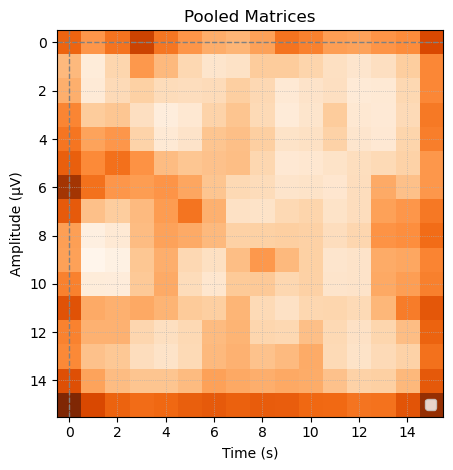

In [31]:
plt.imshow(pooled_matrices[0], cmap='Oranges_r')
plt.title("Pooled Matrices")


plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)

# Add horizontal line at amplitude = 0
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)

plt.xlabel("Time (s)")
plt.ylabel("Amplitude (μV)")
plt.legend()
plt.grid(True, which='both', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()

This heatmap provides a plot of amplitude with respect to time


In [32]:
feature_vectors = []
for pooled_matrix in pooled_matrices:
    feature_vector = pooled_matrix.flatten()
    feature_vectors.append(feature_vector)


print(f"Pooled shape: {pooled_matrices[0].shape}")
print(f"Feature Vector shape: {feature_vectors[0].shape}")

Pooled shape: (16, 16)
Feature Vector shape: (256,)


In [33]:
import torch.nn as nn
class conv_net:
    def __init__(self, input_dim=4096, hidden_dim=1024, output_dim=1, learn_rate=0.01):
        self.W1 = np.random.randn(input_dim, hidden_dim) * 0.01
        self.b1 = np.zeros((1, hidden_dim))
        self.W2 = np.random.randn(hidden_dim, output_dim) * 0.01
        self.b2 = np.zeros((1, output_dim))
        self.learn_rate = learn_rate

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return (x > 0).astype(float)

    def softmax(self, x):
        nn.Softmax2d(x)

    def cross_entropy_loss(self, probs, labels):
        epsilon = 1e-8
        return -np.mean(labels * np.log(probs + epsilon) + (1 - labels) * np.log(1 - probs + epsilon))

    def forward(self, X):
        self.z1 = X @ self.W1 + self.b1
        self.a1 = self.relu(self.z1)
        self.z2 = self.a1 @ self.W2 + self.b2
        self.probs = self.softmax(self.z2)
        return self.probs

    def backward(self, X, y):
        N = y.shape[0]
        dZ2 = self.probs - y.reshape(-1, 1)  # Fix for binary classification
        dW2 = self.a1.T @ dZ2 / N
        db2 = np.sum(dZ2, axis=0, keepdims=True) / N

        dA1 = dZ2 @ self.W2.T
        dZ1 = dA1 * self.relu_derivative(self.z1)
        dW1 = X.T @ dZ1 / N
        db1 = np.sum(dZ1, axis=0, keepdims=True) / N

        self.W1 -= self.learn_rate * dW1
        self.b1 -= self.learn_rate * db1
        self.W2 -= self.learn_rate * dW2
        self.b2 -= self.learn_rate * db2

    def predict(self, X):
        probs = self.forward(X)
        return (probs > 0.5).astype(int).flatten()

In [ ]:
X = np.array(feature_vectors)
y = np.array()

# Initialize model for binary classification
model = conv_net(input_dim=X.shape[1], hidden_dim=1024, output_dim=1, learn_rate=0.01)

losses = []
accuracies = []

epochs = 101
for epoch in range(epochs):
    probs = model.forward(X).flatten()  # shape: (num_samples,)
    loss = model.cross_entropy_loss(probs, y)
    model.backward(X, y)
    preds = (probs > 0.5).astype(int)  # binary prediction
    accuracy = np.mean(preds == y)
    losses.append(loss)
    accuracies.append(accuracy)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")
mean_accuracy_train = np.mean(accuracy)